   ##                         Coursera Capstone Project
###           Topic: Suggesting the best location for setting up a football stadium in Calgary

#### Submitted by Toju Mary Awe  to coursera as the Capstone Project for IBM Professional Certificate in Data Science

### INTRODUCTION/BUSINESS PROBLEM
With the growing number of youth and large young migrants in Canada, Toju Football Academy is looking at building a football stadium in the neighborhoods of Calgary. The aim of this is to attract as many young talents as possible into the sport while also contributing to the development of the game in the country. Data obtained from https://en.wikipedia.org/wiki/Demographics_of_Canada showed that 30% of the Canadian population is less than 25 years old. Calgary, the largest city in Alberta, has a population of about 1.1million people (see https://en.wikipedia.org/wiki/Demographics_of_Calgary#:~:text=Pop.&text=In%20the%202011%20Census%2C%20the,area%20(CMA)%20was%201%2C214%2C839). Toju Football Academy is therefore taking the advantage of this huge young population to set up a football stadium in Calgary. The aim of this project therefore, is to help the Academy suggest the best location to site the football stadium in the neighborhoods of Calgary. 


In [1]:
import requests #library to handle request
from bs4 import BeautifulSoup
import pandas as pd  # library to process data as dataframes
import numpy as np # library to handle data in a vectorized manner 
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values  
import folium      # map rendering library
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans   # import k-means from clustering stage

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### DATA DESCRIPTION
As explained above, the aim for this project is to suggest the best possible location to set up a football stadium in the neighborhood of Calgary.  The data for the purpose of this project would be sourced from: 
a.	Wikipedia. At   https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T  is a list of the neighborhoods in Calgary together with their latitude and longitude coordinates. This dataset would be filtered and cleaned to extract only the borough of Calgary. 
b.	The Forsquare API would be used to get the most common venues in the city of Calgary. 

In [2]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_T')
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find('table', attrs={'class':'wikitable sortable'})
df = pd.read_html(str(table))[0]
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


### Cleaning and Processing the data

In [3]:
df = df[df.Borough != 'Not assigned']  # Dropping the rows where Borough is 'Not assigned'
df = df[df.Latitude != 'Not assigned']
df = df[df.Longitude != 'Not assigned']
df = df[df.Neighborhood != 'Not assigned']
df = df.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)  # Combining the neighborhoods with same Postal Code
df.reset_index(inplace=True)   


# Replacing the neighborhoods which are 'Not assigned' with names of Borough
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned',df['Borough'], df['Neighborhood'])
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T1A,Medicine Hat,Central Medicine Hat,50.036460,-110.679250
1,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.049680,-113.964320
2,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.126060,-114.143158
3,T4A,Airdrie,East Airdrie,51.272450,-113.986980
4,T5A,Edmonton,"West Clareview, East Londonderry",53.5899,-113.4413


In [4]:
df.shape

(97, 5)

In [5]:
df['Latitude'] = pd.to_numeric(df['Latitude'])  # the latitude value is passed into numeric
df['Longitude'] = pd.to_numeric(df['Longitude'])   # the longitude value is passed into numeric

###   Exploring and Clustering the neighborhoods of Calgary

In [6]:
# Get the latitude and longitude coordinates of Calgary
address = "Calgary, Alberta"

geolocator = Nominatim(user_agent="calgary_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary city are 51.0534234, -114.0625892.


In [7]:
# create map of Calgary using latitude and longitude coordinates
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Borough'], 
        df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  

map_calgary

### METHODOLOGY
The result of this cleaned dataset was passed into the Foursquare API to obtain the venues in each neighborhood within the radius of 1500 meters and the limit of 100. The result obtained using the Foursquare API was converted into a DataFrame and grouped by the number of neighborhoods. The result of this shows there are 191 unique categories of venues in the Calgary neighborhood. 

Using the elbow method of calculating the optimal value of K, 3 was the fit value for the Kmeans algorithm. Therefore, the Kmeans cluster algorithm was used to cluster the Calgary neighborhood into 3.


In [8]:
df_calgary = df[df['Borough'].str.contains("Calgary")].reset_index(drop=True)
df_calgary.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100


######  Defining the Foursquare API credentials and version

In [9]:
CLIENT_ID = 'XBZJ2LLGSDOB1DEUIYBO034HQVJA3UWXJVBRRTDV45OGDO4B' # your Foursquare ID
CLIENT_SECRET = 'JUPI5V1DMCOBVGMPMHUU5ZTLZ3HIMA4QQYVGOFN2ULTPY4MS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XBZJ2LLGSDOB1DEUIYBO034HQVJA3UWXJVBRRTDV45OGDO4B
CLIENT_SECRET:JUPI5V1DMCOBVGMPMHUU5ZTLZ3HIMA4QQYVGOFN2ULTPY4MS


In [10]:
neighborhood_name = df_calgary.loc[0, 'Neighborhood']
print('The first neighborhood is ', neighborhood_name)

The first neighborhood is  Penbrooke Meadows, Marlborough


In [11]:
neighborhood_latitude = df_calgary.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_calgary.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Penbrooke Meadows, Marlborough are 51.04968, -113.96432.


In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

C:\Users\schor\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Bob Bahan Aquatic & Fitness Centre,Gym / Fitness Center,51.041609,-113.964319
1,Pho Dau Bo,Vietnamese Restaurant,51.037592,-113.963598
2,Olive Garden,Italian Restaurant,51.052937,-113.982449
3,Red Lobster,Seafood Restaurant,51.054367,-113.982448
4,7-Eleven,Convenience Store,51.045519,-113.957341
5,TD Canada Trust,Bank,51.052399,-113.970643
6,The Old Spaghetti Factory,Italian Restaurant,51.055774,-113.981094
7,Shoppers Drug Mart,Pharmacy,51.052750,-113.977420
8,7-Eleven,Convenience Store,51.051550,-113.980266
9,Dairy Queen,Ice Cream Shop,51.037465,-113.968082


In [15]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

34 venues were returned by Foursquare.


In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
calgary_venues = getNearbyVenues(names=df_calgary['Neighborhood'],
                                   latitudes=df_calgary['Latitude'],
                                   longitudes=df_calgary['Longitude']
                                  )

In [18]:
print(calgary_venues.shape)
calgary_venues.head()

(1689, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Bob Bahan Aquatic & Fitness Centre,51.041609,-113.964319,Gym / Fitness Center
1,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Pho Dau Bo,51.037592,-113.963598,Vietnamese Restaurant
2,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Olive Garden,51.052937,-113.982449,Italian Restaurant
3,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,Red Lobster,51.054367,-113.982448,Seafood Restaurant
4,"Penbrooke Meadows, Marlborough",51.04968,-113.96432,7-Eleven,51.045519,-113.957341,Convenience Store


In [19]:
calgary_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Braeside, Cedarbrae, Woodbine",34,34,34,34,34,34
"Brentwood, Collingwood, Nose Hill",26,26,26,26,26,26
"Bridgeland, Greenview, Zoo, YYC",100,100,100,100,100,100
"City Centre, Calgary Tower",100,100,100,100,100,100
"Connaught, West Victoria Park",100,100,100,100,100,100
"Cranston, Auburn Bay, Mahogany",18,18,18,18,18,18
"Dalhousie, Edgemont, Hamptons, Hidden Valley",7,7,7,7,7,7
"Discovery Ridge, Signal Hill, West Springs, Christie Estates, Patterson, Cougar Ridge",13,13,13,13,13,13
"Douglas Glen, McKenzie Lake, Copperfield, East Shepard",15,15,15,15,15,15


In [20]:
print('There are {} uniques categories.'.format(len(calgary_venues['Venue Category'].unique())))

There are 191 uniques categories.


In [21]:
# one hot encoding
calgary_onehot = pd.get_dummies(calgary_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
calgary_onehot['Neighborhood'] = calgary_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [calgary_onehot.columns[-1]] + list(calgary_onehot.columns[:-1])
calgary_onehot = calgary_onehot[fixed_columns]

calgary_onehot.head()

,Yoga Studio,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bakery,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
calgary_grouped = calgary_onehot.groupby('Neighborhood').mean().reset_index()
calgary_grouped.head()

,Neighborhood,Yoga Studio,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Braeside, Cedarbrae, Woodbine",0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.000000,0.0,0.00,0.0,0.00,0.0,0.00,0.029412,0.0,0.0
1,"Brentwood, Collingwood, Nose Hill",0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.038462,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,0.0,0.0
2,"Bridgeland, Greenview, Zoo, YYC",0.00,0.00,0.0,0.0,0.03,0.0,0.0,0.0,0.01,...,0.000000,0.0,0.00,0.0,0.05,0.0,0.00,0.000000,0.0,0.0
3,"City Centre, Calgary Tower",0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.01,...,0.000000,0.0,0.02,0.0,0.03,0.0,0.01,0.010000,0.0,0.0
4,"Connaught, West Victoria Park",0.01,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.000000,0.0,0.02,0.0,0.03,0.0,0.00,0.000000,0.0,0.0


In [23]:
calgary_grouped.shape

(34, 191)

####  Check the 10 most common venues in each neighborhood.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = calgary_grouped['Neighborhood']

for ind in np.arange(calgary_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(calgary_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Braeside, Cedarbrae, Woodbine",Coffee Shop,Gas Station,Pub,Fast Food Restaurant,Shopping Mall,Pool,Sushi Restaurant,Pet Store,Pharmacy,Pizza Place
1,"Brentwood, Collingwood, Nose Hill",Pub,Convenience Store,Furniture / Home Store,Park,Smoothie Shop,Clothing Store,Coffee Shop,Seafood Restaurant,Restaurant,Pharmacy
2,"Bridgeland, Greenview, Zoo, YYC",Chinese Restaurant,Pub,Vietnamese Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Sushi Restaurant,Scenic Lookout,Fast Food Restaurant,Convenience Store
3,"City Centre, Calgary Tower",Restaurant,Pub,Coffee Shop,Pizza Place,Steakhouse,Bakery,Vietnamese Restaurant,Café,Diner,Performing Arts Venue
4,"Connaught, West Victoria Park",Restaurant,Bar,Pizza Place,Bakery,Pub,Vietnamese Restaurant,Lounge,Brewery,Italian Restaurant,Steakhouse


##### Clustering of the neighborhood

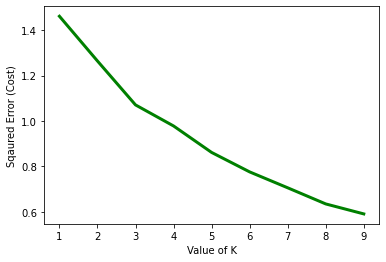

In [25]:
import matplotlib.pyplot as plt

calgary_grouped_clustering = calgary_grouped.drop('Neighborhood', 1)
cost =[] 
for i in range(1, 10): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(calgary_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 
  
# the point of the elbow is the  
# most optimal value for choosing k

Analysing the graph suggest the value of 3 as the best fit for k


In [26]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(calgary_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

calgary_merged = df_calgary

# merge calgary_grouped with calgary_data to add latitude/longitude for each neighborhood
calgary_merged = calgary_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
calgary_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,T2A,Calgary,"Penbrooke Meadows, Marlborough",51.04968,-113.964320,1,Fast Food Restaurant,Vietnamese Restaurant,Pharmacy,Grocery Store,Italian Restaurant,Ice Cream Shop,Restaurant,Convenience Store,Food Court,Seafood Restaurant
1,T3A,Calgary,"Dalhousie, Edgemont, Hamptons, Hidden Valley",51.12606,-114.143158,0,Convenience Store,Gas Station,Chinese Restaurant,Gym / Fitness Center,Trail,General Entertainment,Women's Store,Food Truck,Garden,Furniture / Home Store
2,T2B,Calgary,"Forest Lawn, Dover, Erin Woods",51.03180,-113.978600,1,Grocery Store,Vietnamese Restaurant,Fast Food Restaurant,Convenience Store,Bank,Sandwich Place,Fried Chicken Joint,Coffee Shop,Bowling Alley,Gym / Fitness Center
3,T3B,Calgary,"Montgomery, Bowness, Silver Springs, Greenwood",51.08090,-114.161600,1,Coffee Shop,Restaurant,Clothing Store,Park,Grocery Store,Gas Station,Pizza Place,Convenience Store,Shopping Mall,Chinese Restaurant
4,T2C,Calgary,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",50.98780,-114.000100,1,Pizza Place,Coffee Shop,Pharmacy,Construction & Landscaping,Indian Restaurant,Spa,Gas Station,Skating Rink,Cheese Shop,Clothing Store


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        calgary_merged['Latitude'], 
        calgary_merged['Longitude'], 
        calgary_merged['Neighborhood'], 
        calgary_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### RESULTS
The result of our clustering shows majority of the neighborhoods belong to the second cluster (cluster '1') while the remaining neighborhoods were sparsely distributed among the other two clusters. 


Cluster '0'

In [34]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 0, calgary_merged.columns[[2] + list(range(4, calgary_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Dalhousie, Edgemont, Hamptons, Hidden Valley",-114.143158,0,Convenience Store,Gas Station,Chinese Restaurant,Gym / Fitness Center,Trail,General Entertainment,Women's Store,Food Truck,Garden,Furniture / Home Store
9,"Hawkwood, Arbour Lake, Citadel, Ranchlands, Ro...",-114.179600,0,Gym / Fitness Center,Pizza Place,Convenience Store,Italian Restaurant,Sandwich Place,Thrift / Vintage Store,Other Great Outdoors,Garden,Furniture / Home Store,Frozen Yogurt Shop
14,"Thorncliffe, Tuxedo Park",-114.071400,0,Convenience Store,Gas Station,Breakfast Spot,Indian Restaurant,Hardware Store,Ice Cream Shop,Dim Sum Restaurant,Park,Restaurant,Furniture / Home Store


Cluster '1'

In [35]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 1, calgary_merged.columns[[2] + list(range(4, calgary_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Penbrooke Meadows, Marlborough",-113.96432,1,Fast Food Restaurant,Vietnamese Restaurant,Pharmacy,Grocery Store,Italian Restaurant,Ice Cream Shop,Restaurant,Convenience Store,Food Court,Seafood Restaurant
2,"Forest Lawn, Dover, Erin Woods",-113.97860,1,Grocery Store,Vietnamese Restaurant,Fast Food Restaurant,Convenience Store,Bank,Sandwich Place,Fried Chicken Joint,Coffee Shop,Bowling Alley,Gym / Fitness Center
3,"Montgomery, Bowness, Silver Springs, Greenwood",-114.16160,1,Coffee Shop,Restaurant,Clothing Store,Park,Grocery Store,Gas Station,Pizza Place,Convenience Store,Shopping Mall,Chinese Restaurant
4,"Lynnwood Ridge, Ogden, Foothills Industrial, G...",-114.00010,1,Pizza Place,Coffee Shop,Pharmacy,Construction & Landscaping,Indian Restaurant,Spa,Gas Station,Skating Rink,Cheese Shop,Clothing Store
5,"Rosscarrock, Westgate, Wildwood, Shaganappi, S...",-114.09800,1,Coffee Shop,Pub,Pizza Place,Sandwich Place,Grocery Store,Vietnamese Restaurant,Restaurant,Mexican Restaurant,Indian Restaurant,Japanese Restaurant
6,"Bridgeland, Greenview, Zoo, YYC",-114.06140,1,Chinese Restaurant,Pub,Vietnamese Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Sushi Restaurant,Scenic Lookout,Fast Food Restaurant,Convenience Store
7,"Lakeview, Glendale, Killarney, Glamorgan",-114.13420,1,Pizza Place,Coffee Shop,Convenience Store,Korean Restaurant,Gas Station,Supermarket,Gym,Japanese Restaurant,Snack Place,Sporting Goods Shop
8,"Inglewood, Burnsland, Chinatown, East Victoria...",-114.05990,1,Restaurant,Hotel,Pub,Cocktail Bar,Italian Restaurant,Coffee Shop,Steakhouse,Bakery,Bar,Café
10,"Highfield, Burns Industrial",-114.06310,1,Coffee Shop,American Restaurant,Grocery Store,Restaurant,Burger Joint,Pizza Place,Pharmacy,Sushi Restaurant,Department Store,Korean Restaurant
11,"Discovery Ridge, Signal Hill, West Springs, Ch...",-114.18150,1,Gas Station,Trail,Grocery Store,Liquor Store,Convenience Store,Salon / Barbershop,Bar,Bank,Dog Run,Restaurant


Cluster '2'

In [36]:
calgary_merged.loc[calgary_merged['Cluster Labels'] == 2, calgary_merged.columns[[2] + list(range(5, calgary_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Northeast Calgary,2,Hotel,Coffee Shop,Sporting Goods Shop,American Restaurant,Gas Station,Brewery,Gym / Fitness Center,Football Stadium,Gastropub,Garden


### DISCUSSION
The analysis of the result produced by the clustering of Calgary neighborhoods revealed that the third cluster has a football stadium and also a lot of sporting activities.  For the second cluster, there is also the presence of a football stadium, although the cluster reveals the preponderance of restaurants, shopping mall and the likes. Looking at the parameter we set at the beginning of this project, we may want to look away from second and the third cluster in setting our football stadium. In analyzing the first cluster, it is evident that there is no presence of any football stadium among the top ten venues in the cluster. 




### CONCLUSION
Comparing the parameters we set at the beginning of this project which are:
a.	Locations not already crowded with the presence of football stadium or any other sporting centers
b.	Locations where there is no football stadium.
According to the result of our analysis, the Northeast Calgary seems to be the center of sporting activities since there is a football stadium within the vicinity of the neighborhood. With the result we obtained from our clustering analysis, the best neighborhoods to site our football stadium are: Dalhousie, Edgemont, Hamptons, Hidden Valley, Hawkwood, Arbour Lake, Citadel, Ranchlands, Thorncliffe and Tuxedo Park, since these neighborhood do not have much of sporting activities. 

